# Concept discovery on dSprites

In [1]:
import sys
sys.path.append('..')
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import simplify_logic
import time
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree, export_text
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import seaborn as sns

import deep_logic as dl
from deep_logic.utils.base import validate_network, set_seed, tree_to_formula
from deep_logic.utils.layer import prune_logic_layers
from deep_logic import logic

from dSprites.dSprites_loader import load_dsprites, concept_filters, get_shape_scale
from dSprites.dSprites_style_I2C import i2c_style

results_dir = 'results_ll/dsprites_h'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

models_dir = 'models_ll/dsprites_h'
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

## Load dSprites data

In [2]:
def get_data(path):
    # Load dataset specified by schema
    dataset_schema = 'small_skip'
    # dataset_schema = 'big_skip'

    # Get filtered concept values
    shape_range, scale_range, rot_range, x_pos_range, y_pos_range = concept_filters(dataset_schema)

    # Define function for filtering out specified concept values only
    def c_filter_fn(concepts):
        in_shape_range = (concepts[1] in shape_range)
        in_scale_range = (concepts[2] in scale_range)
        in_rot_range = (concepts[3] in rot_range)
        in_x_range = (concepts[4] in x_pos_range)
        in_y_range = (concepts[5] in y_pos_range)

        return (in_shape_range and in_scale_range and in_rot_range and in_x_range and in_y_range)

    label_fn = get_shape_scale(shape_range, scale_range)
    
    # Load dataset
    x_train, y_train, x_val, y_val, x_test, y_test, c_train, c_val, c_test, c_names = load_dsprites(path,
                                                                               c_filter_fn=c_filter_fn,
                                                                               label_fn=label_fn,
                                                                               train_test_split_flag=True)


    return x_train, y_train, x_val, y_val, x_test, y_test, c_train, c_val, c_test, c_names

# Load the model, as well as input, label, and concept data
data = get_data(path='./dSprites/data/dsprites.npz')
x_train, y_train, x_val, y_val, x_test, y_test, c_train, c_val, c_test, c_names = data
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.LongTensor(y_val)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
c_train = torch.FloatTensor(c_train)
c_val = torch.FloatTensor(c_val)
c_test = torch.FloatTensor(c_test)
print("Data loaded successfully...")

x_train shape: (20993, 3, 64, 64)
c_train shape: (20993, 50)
y_train shape: (20993, 18)
Number of images in x_train 20993
Number of images in x_val 10341
Number of images in x_test 5530
Data loaded successfully...


In [35]:
y_train2 = y_train[:, [0, 1]]
y_train2[:, 1] = 1 - y_train[:, 1]
y_train2[:, 0].sum() + (1-y_train2[:, 0]).sum()

tensor(20993)

In [19]:
y_val2 = y_val[:, [0, 1]]
y_val2[:, 1] = 1 - y_val[:, 1]
y_test2 = y_test[:, [0, 1]]
y_test2[:, 1] = 1 - y_test[:, 1]

## Generate data loaders

In [3]:
args = {
    'models_dir': './models/dSprites/', 
    'model_style': 'CBM',
    'seed': 0,
    'batch_size': 128,
}

if not os.path.isdir(args['models_dir']):
    os.makedirs(args['models_dir'])

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=False)
val_dataset = TensorDataset(x_val, y_val)
valid_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

# Model
## Define CNN architecture

In [5]:
n_concepts = 32
n_outputs = y_train.size(1)

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(8, n_concepts, 3, padding=1)
        self.log1 = dl.nn.XLogicConv2d(in_channels=n_concepts, channel_size=62, activation='leaky_relu')
        self.fc5 = torch.nn.Linear(n_concepts, 32)
        self.fc6 = torch.nn.Linear(32, n_outputs)
        self.log2 = dl.nn.XLogic(n_outputs, top=True, activation='leaky_relu')
        # max pooling
        self.pool = torch.nn.MaxPool2d(4, 1, padding=1)
        self.filter_output = None

    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        self.filter_output = x
        x = self.log1(x)
        x = F.leaky_relu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        x = self.log2(x)
        return F.softmax(x, dim=1)

## Train model

### Whitening Loss function

In [7]:
# the target covariance matrix is diagonal
cov_objective = torch.eye(n_concepts).to(device)

def whitening_loss(model):
    loss = 0
    for module in model.children():
        if isinstance(module, dl.nn.XLogicConv2d):
            # compute covariance matrix of activations
            cov = 1 / (n_concepts - 1) * torch.matmul(module.conceptizator.concepts.T, module.conceptizator.concepts)
            loss += torch.norm(cov - cov_objective, p=2)
    return loss, cov

### L1-regularization loss

In [8]:
def l1_loss(model):
    loss = 0
    for module in model.children():
        if isinstance(module, dl.nn.XLogicConv2d):
            loss += torch.norm(module.weight, 1) + torch.norm(module.bias, 1)
    return loss

In [10]:
model = Net()
model.cuda()

# if os.path.isfile('./models_ll/dsprites_h/trained_model_h3.pt'):
#     # load trained model
#     model.load_state_dict(torch.load('./models_ll/dsprites_h/trained_model_h3.pt'))

# else:
epochs = 10
set_seed(0)
need_pruning = True

# tracks validation loss change after each epoch
minimum_validation_loss = np.inf

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(1, epochs + 1):

    train_loss = 0
    valid_loss = 0

    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        data, target = data.cuda(), target.cuda()
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target.argmax(dim=1)) + 0.01 * whitening_loss(model)[0] + 0.001 * l1_loss(model)

        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target.argmax(dim=1))
        # update validation loss
        valid_loss += loss.item() * data.size(0)

    # average loss calculations
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)}\nValidation Loss: {round(valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if valid_loss <= minimum_validation_loss and epoch > 4:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
        torch.save(model.state_dict(), './models_ll/dsprites_h/trained_model_h3.pt')
        minimum_validation_loss = valid_loss
        print('Saving New Model')

    # tracking test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(n_outputs))
    class_total = list(0. for i in range(n_outputs))

    # test steps
    model.eval()
    for batch_index, (data, target) in enumerate(test_loader):
        # moves tensors to GPU
        data, target = data.cuda(), target.cuda() % 2
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target.argmax(dim=1))

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.argmax(dim=1).data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
            correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(n_outputs):
            label = target.argmax(dim=1).data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    for i in range(n_outputs):
        print(f'Test Accuracy of class "{i}": {round(100 * class_correct[i] / class_total[i], 2)}%')

#     cov_np = whitening_loss(model)[1].cpu().detach().numpy()
#     plt.figure()
#     sns.heatmap(cov_np)
#     plt.show()

model.load_state_dict(torch.load('./models_ll/dsprites_h/trained_model_h3.pt'))

Current Epoch: 1
Training Loss: 2.968633
Validation Loss: 2.889379
Test Accuracy of class "0": 0.0%
Test Accuracy of class "1": 0.0%
Test Accuracy of class "2": 0.0%
Test Accuracy of class "3": 29.63%
Test Accuracy of class "4": 40.62%
Test Accuracy of class "5": 0.0%
Test Accuracy of class "6": 0.0%
Test Accuracy of class "7": 0.0%
Test Accuracy of class "8": 0.0%
Test Accuracy of class "9": 0.0%
Test Accuracy of class "10": 0.0%
Test Accuracy of class "11": 0.0%
Test Accuracy of class "12": 0.0%
Test Accuracy of class "13": 0.0%
Test Accuracy of class "14": 0.0%
Test Accuracy of class "15": 0.0%
Test Accuracy of class "16": 0.0%
Test Accuracy of class "17": 0.0%
Current Epoch: 2
Training Loss: 2.950419
Validation Loss: 2.812815
Test Accuracy of class "0": 0.0%
Test Accuracy of class "1": 0.0%
Test Accuracy of class "2": 0.0%
Test Accuracy of class "3": 0.0%
Test Accuracy of class "4": 0.0%
Test Accuracy of class "5": 97.83%
Test Accuracy of class "6": 0.0%
Test Accuracy of class "7":

<All keys matched successfully>

In [ ]:
model.filter_output.shape
32*62*62
n_outputs

# Concepts' visualization

### Feed the network with validation data

In [11]:
model.eval()
x_subset, y_subset, pred_subset = [], [], []
for i, (x_subset_i, y_subset_i) in enumerate(iter(train_loader)):
    x_subset.append(x_subset_i)
    y_subset.append(y_subset_i)
    pred_subset.append(model.cpu()(x_subset_i))
    if i > 5: break

x_subset = torch.cat(x_subset)
y_subset = torch.cat(y_subset)
pred_subset = torch.cat(pred_subset)

model.cpu()(x_subset)
symbols = model.log1.conceptizator.concepts

### Covariance matrix in the concept layer

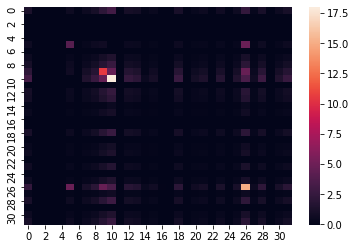

In [12]:
cov_objective = cov_objective.cpu()
cov_np = whitening_loss(model.cpu())[1].cpu().detach().numpy()

plt.figure()
sns.heatmap(cov_np)
plt.show()

## Visualize concepts 

### Concept filters

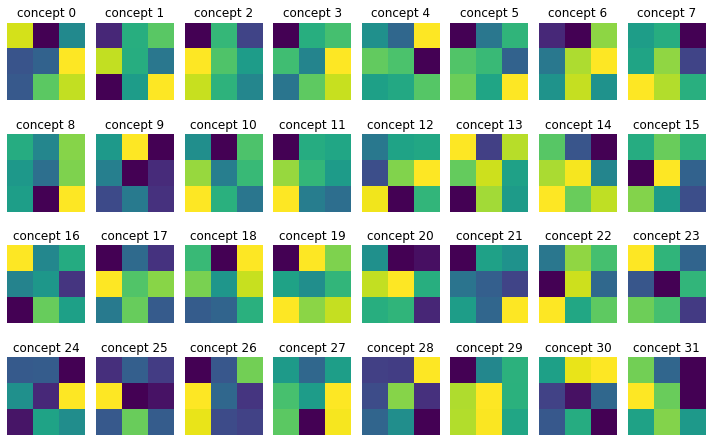

In [13]:
plt.figure(figsize=[10, 8])
max_c = 8
max_r = 5
for i in range(model.conv2.weight.size(0)):
    plt.subplot(max_r, max_c, i + 1)
    plt.title(f'concept {i}')
    plt.imshow(model.conv2.weight[i].sum(dim=0).detach().numpy())
    plt.axis('off')
    if i >= (max_c * max_r - 1): break
plt.tight_layout()
plt.savefig('mnist_filters.png')
plt.show()

### Concept embeddings

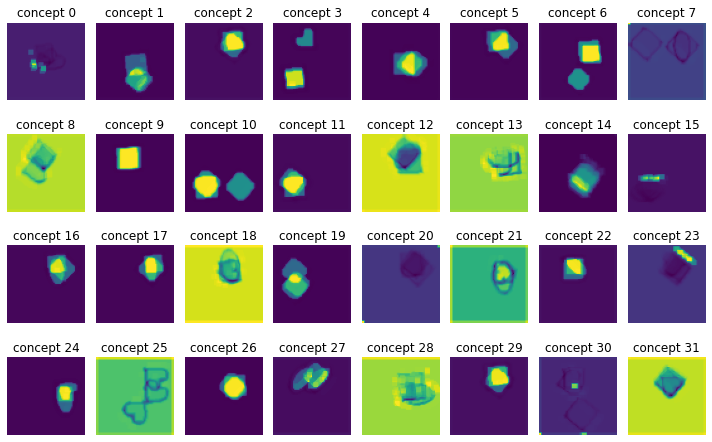

In [19]:
plt.figure(figsize=[10, 8])
max_c = 8
max_r = 5
for q, c in enumerate(torch.topk(symbols.abs(), k=3, dim=0)[1].T):
    plt.subplot(max_r, max_c, q + 1)
    plt.title(f'concept {q}')
    plt.imshow((model.filter_output[c, q] + 1).sum(dim=0).cpu().detach().numpy())
    plt.axis('off')
    if q >= (max_c * max_r - 1): break
plt.tight_layout()
plt.savefig('mnist_filters_output.png')
plt.show()

### Input images associated with concepts

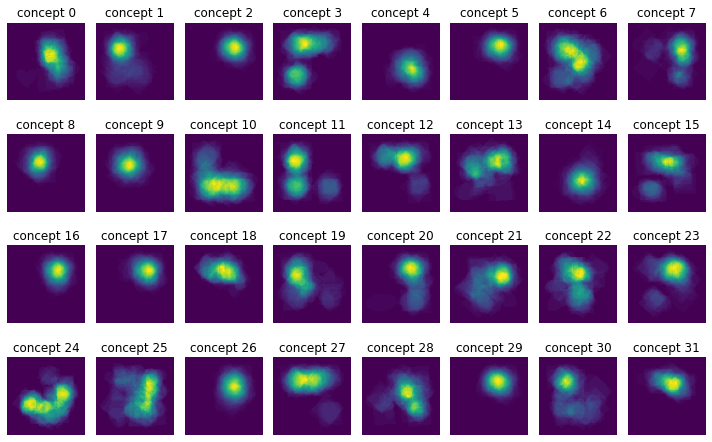

In [18]:
plt.figure(figsize=[10, 8])
max_c = 8
max_r = 5
for q, c in enumerate(torch.topk(symbols.abs(), k=100, dim=0)[1].T):
    plt.subplot(max_r, max_c, q + 1)
    plt.title(f'concept {q}')
    #     plt.imshow((x_subset[c, 0]+1).sum(dim=0).exp())
    plt.imshow((x_subset[c, 0] + 1).sum(dim=0))
    #     plt.figure(figsize=[10,2])
    #     for j, i in enumerate(c):
    #         plt.subplot(1, len(c), j+1)
    #         plt.imshow(x_subset[i, 0])
    plt.axis('off')
    if q >= (max_c * max_r - 1): break
plt.tight_layout()
plt.savefig('mnist_concepts.png')
plt.show()

# FOL formulas

In [ ]:
# threshold = 0.

# # positive class
# target_class = 1
# start = time.time()
# class_explanation, class_explanations = logic.explain_class(model.cpu(),
#                                                             x_subset,
#                                                             symbols>threshold,
#                                                             y_subset % 2,
#                                                             target_class=target_class,
#                                                             simplify=True,
#                                                             topk_explanations=5)
# elapsed_time = time.time() - start
# print(class_explanations['layer_5-neuron_1'])
# class_explanation = class_explanations['layer_5-neuron_1']

# # %%

# # # model.eval()
# # # x_subset, y_subset = next(iter(valid_loader))
# pred_subset = model.cpu()(x_subset)
# # # print(class_explanation)
# y_formula = dl.logic.metrics.predictions(class_explanation, target_class,
#                                          model.log1.conceptizator.concepts>threshold,
#                                          y_subset % 2, metric=accuracy_score)
# y_pred = pred_subset[:, 0].detach().cpu().numpy()
# y_true = (y_subset.to(device) % 2 < 0.5).detach().cpu().numpy()
# print(y_formula.shape)
# print(y_pred.shape)
# print(y_true.shape)

# # %%

# # concept_consistency, formula_consistency,
# accuracy_model = accuracy_score(y_pred>0.5, y_true)
# accuracy = accuracy_score(y_formula, y_true)
# fidelity = dl.logic.metrics.fidelity(y_formula>0.5, y_pred>0.5)
# complexity = dl.logic.metrics.complexity(class_explanation)
# print(f'Accuracy: {accuracy}')
# print(f'Fidelity: {fidelity}')
# print(f'Complexity: {complexity}')